In [1]:
!pwd

/mnt/c/Users/cltng/OneDrive/chatgpt/dev_nbs


In [11]:
import torch
from typing import Optional, Dict
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from IPython.display import clear_output

import gymnasium as gym
import torch
import numpy as np

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure
tensorboard_log = './ppotb'
device='cpu'
inbred_parent_data = np.load('../nbs/data/g2f_ch10.npy', allow_pickle=True)

@dataclass
class SimulationConfig:
    n_markers: int = 1000
    starting_parents: int = 20
    pop_size: int = 1000
    h2: float = 1.0
    sparse_reward: bool = True

class Genome:
    def __init__(self, n_markers: int):
        self.ploidy: int = 2
        self.n_markers: int = n_markers

    def __repr__(self) -> str:
        return f"Genome(ploidy={self.ploidy}, n_markers={self.n_markers})"

class Population:
    def __init__(self, pop_size: int, haplotypes:torch.tensor, genome: Genome, device: torch.device):
        self.pop_size: int = pop_size
        self.genome: Genome = genome
        self.haplotypes: torch.Tensor = haplotypes
        self.device: torch.device = device
        



    def to(self, device: torch.device) -> 'Population':
        self.device = device
        self.haplotypes = self.haplotypes.to(device)
        return self

    def __repr__(self) -> str:
        return f"Population(pop_size={self.pop_size}, genome={self.genome}, device={self.device})"




class Trait:
    def __init__(self, genome: Genome, population: Population, target_mean: float = 0.0, target_variance: float = 1.0):
        self.genome: Genome = genome
        self.device: torch.device = population.device
        self.target_mean: float = target_mean
        self.target_variance: float = target_variance

        raw_effects = torch.randn(genome.n_markers, device=self.device)
        centered_effects = raw_effects - raw_effects.mean()
        dosages = population.haplotypes.sum(dim=1)
        founder_values = torch.einsum('ij,j->i', dosages, centered_effects)
        founder_mean = founder_values.mean()
        founder_var = founder_values.var()

        scaling_factor = torch.sqrt(self.target_variance / founder_var)
        self.effects: torch.Tensor = centered_effects * scaling_factor
        self.intercept: torch.Tensor = (torch.tensor(self.target_mean, device=self.device) - founder_mean).detach()

    def to(self, device: torch.device) -> 'Trait':
        self.device = device
        self.effects = self.effects.to(device)
        self.intercept = self.intercept.to(device)
        return self

    def __repr__(self) -> str:
        return f"Trait(target_mean={self.target_mean}, target_variance={self.target_variance}, device={self.device})"

class SimOps:
    @staticmethod
    def score_population(population: Population, trait: Trait, h2: float = 1.0) -> torch.Tensor:
        dosages = population.haplotypes.sum(dim=1)
        breeding_values = torch.einsum('ij,j->i', dosages, trait.effects)

        bv_var = breeding_values.var()
        if bv_var == 0 or h2 >= 1:
            return breeding_values

        env_variance = (1 - h2) / h2 * bv_var.item()
        env_std = torch.sqrt(torch.tensor(env_variance, device=population.device))
        env_effects = torch.randn_like(breeding_values) * env_std
        return breeding_values + env_effects + trait.intercept


    @staticmethod
    def truncation_selection(population: Population, phenotypes: torch.Tensor, selection_intensity: float) -> torch.Tensor:
        assert 0 < selection_intensity <= 1, "Selection intensity must be between 0 and 1"
        assert population.haplotypes.shape[0] == phenotypes.shape[0], "Mismatch between population size and phenotypes"

        num_select = max(1, min(int(selection_intensity * population.pop_size), population.pop_size - 1))
        _, top_indices = torch.topk(phenotypes, num_select)
        return population.haplotypes[top_indices]


    @staticmethod
    def meiosis(selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        num_parents, ploidy, num_markers = selected_haplotypes.shape

        # Repeat each parent's haplotypes num_gametes_per_parent times
        expanded_haplotypes = selected_haplotypes.repeat_interleave(num_gametes_per_parent, dim=0)

        # The rest of the function remains largely the same, but operates on the expanded haplotypes
        total_gametes = num_parents * num_gametes_per_parent

        crossover_points = torch.randint(1, num_markers, (total_gametes, num_crossovers), device=selected_haplotypes.device)
        crossover_points, _ = torch.sort(crossover_points, dim=1)

        crossover_mask = torch.zeros((total_gametes, num_markers), dtype=torch.bool, device=selected_haplotypes.device)
        crossover_mask.scatter_(1, crossover_points, 1)
        crossover_mask = torch.cumsum(crossover_mask, dim=1) % 2 == 1

        crossover_mask = crossover_mask.unsqueeze(1).expand(-1, ploidy, -1)

        start_chromosome = torch.randint(0, ploidy, (total_gametes, 1), device=selected_haplotypes.device)
        start_mask = start_chromosome.unsqueeze(-1).expand(-1, -1, num_markers)

        final_mask = crossover_mask ^ start_mask.bool()

        offspring_haplotypes = torch.where(final_mask, expanded_haplotypes, expanded_haplotypes.roll(shifts=1, dims=1))

        # Return only the first haplotype for each meiosis event
        return offspring_haplotypes[:, 0, :]
    @staticmethod
    def check_cuda(tensor: torch.Tensor, name: str) -> None:
        print(f"{name} is on: {tensor.device}")


    @staticmethod
    def random_cross(gamete_tensor: torch.Tensor, total_crosses: int) -> torch.Tensor:
        num_gametes, n_markers = gamete_tensor.shape

        # Double the gamete tensor until we have enough for the total crosses
        while num_gametes < 2 * total_crosses:
            gamete_tensor = torch.cat([gamete_tensor, gamete_tensor], dim=0)
            num_gametes *= 2

        # Randomly select gametes for crossing
        gamete_indices = torch.randperm(num_gametes, device=gamete_tensor.device)
        parent1_indices = gamete_indices[:total_crosses]
        parent2_indices = gamete_indices[total_crosses:2*total_crosses]

        # Create the new population haplotype tensor
        new_population = torch.stack([
            gamete_tensor[parent1_indices],
            gamete_tensor[parent2_indices]
        ], dim=1)

        return new_population
    
def grab_inbred_parents(starting_parents, genome, device=device):

        inbred_data = inbred_parent_data
        
        if starting_parents > inbred_data.shape[0]:
            raise ValueError("Total parents requested exceed the number of available parents.")
        if genome.n_markers > inbred_data.shape[2]:
            raise ValueError("Total markers requested exceed the number of available markers.")
        # Randomly sample parents
        sampled_parents_indices = np.random.choice(inbred_data.shape[0], starting_parents, replace=False)
        sampled_parents = inbred_data[sampled_parents_indices, :, :]
        # Randomly sample markers
        sampled_markers_indices = np.random.choice(inbred_data.shape[2], genome.n_markers, replace=False)
        return torch.tensor(sampled_parents[:, :, sampled_markers_indices], device=device).float()

##################

class SimParams:
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.genome = Genome(config.n_markers)
        self.population = Population(config.pop_size, grab_inbred_parents(5,self.genome), self.genome,device)
        f1 = self.perform_meiosis(self.population.haplotypes, num_crossovers=3, num_gametes_per_parent=((2000//self.population.haplotypes.shape[0]) *self.population.haplotypes.shape[0] + 100))
        self.create_next_generation(f1, total_crosses=2000)
        num_gametes_per_parent = (self.population.haplotypes.shape[0] / config.pop_size) + 2 
        segregating_pop = self.perform_meiosis(self.population.haplotypes, num_crossovers=3, num_gametes_per_parent=100)
        self.create_next_generation(segregating_pop, total_crosses=config.pop_size)

        
        self.trait = Trait(self.genome, self.population)


    def score_population(self, h2: Optional[float] = None) -> torch.Tensor:
        h2 = h2 if h2 is not None else self.config.h2
        return SimOps.score_population(self.population, self.trait, h2)

    def truncation_selection(self, selection_intensity: Optional[float] = None, phenotypes: Optional[torch.Tensor] = None) -> torch.Tensor:
        selection_intensity = selection_intensity if selection_intensity is not None else self.config.selection_intensity
        if phenotypes is None:
            phenotypes = self.score_population()
        return SimOps.truncation_selection(self.population, phenotypes, selection_intensity)

    def check_device(self) -> None:
        SimOps.check_cuda(self.population.haplotypes, "Population haplotypes")
        SimOps.check_cuda(self.trait.effects, "Trait effects")
        SimOps.check_cuda(self.trait.intercept, "Trait intercept")

    def to(self, device: torch.device) -> 'SimParams':
        self.device = device
        self.population = self.population.to(device)
        self.trait = self.trait.to(device)
        return self
    def perform_meiosis(self, selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        return SimOps.meiosis(selected_haplotypes, num_crossovers, num_gametes_per_parent)

    def create_next_generation(self, gametes: torch.Tensor, total_crosses: int) -> None:
        new_population_haplotypes = SimOps.random_cross(gametes, total_crosses)
        # assert new_population_haplotypes.shape[0] == self.config.pop_size, "Population size changed unexpectedly"
        self.population.haplotypes = new_population_haplotypes
        self.population.pop_size = total_crosses



In [24]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from IPython.display import clear_output

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0, log_interval=100, plot_interval=1000, window_size=100, max_generations=10, baseline=None):
        super().__init__(verbose)
        self.log_interval = log_interval
        self.plot_interval = plot_interval
        self.window_size = window_size
        self.step_counter = 0
        self.generation_data = {}
        self.moving_avg_data = {}
        self.writer = None
        self.max_generations = max_generations
        self.action_history = {gen: [] for gen in range(max_generations+1)}
        self.baseline = baseline

    def _on_training_start(self):
        self.writer = SummaryWriter(self.logger.dir)

    def _scale_action(self, action):
        return np.clip((action + 1) / 2, 0, 1)

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        current_generation = info['current_generation']
        raw_action = self.locals['actions'][0][0]
        scaled_action = self._scale_action(raw_action)

        if current_generation not in self.generation_data:
            self.generation_data[current_generation] = {
                'max_phenotypes': [],
                'genetic_variances': [],
                'timesteps': [],
                'actions': []
            }
            self.moving_avg_data[current_generation] = {
                'max_phenotypes': [],
                'genetic_variances': [],
                'timesteps': [],
                'actions': []
            }

        self.generation_data[current_generation]['max_phenotypes'].append(info['max_phenotype'])
        self.generation_data[current_generation]['genetic_variances'].append(info['genetic_variance'])
        self.generation_data[current_generation]['timesteps'].append(self.num_timesteps)
        self.generation_data[current_generation]['actions'].append(scaled_action)

        self.step_counter += 1

        if self.step_counter % self.log_interval == 0:
            self._update_moving_averages()

        if self.step_counter % self.plot_interval == 0:
            self._log_to_tensorboard()
            self._plot_data()

        return True

    def _update_moving_averages(self):
        for gen in self.generation_data:
            data = self.generation_data[gen]
            if len(data['max_phenotypes']) >= self.window_size:
                avg_phenotype = np.mean(data['max_phenotypes'][-self.window_size:])
                avg_genetic_variance = np.mean(data['genetic_variances'][-self.window_size:])
                avg_action = np.mean(data['actions'][-self.window_size:])
                avg_timestep = data['timesteps'][-1]
                self.moving_avg_data[gen]['max_phenotypes'].append(avg_phenotype)
                self.moving_avg_data[gen]['genetic_variances'].append(avg_genetic_variance)
                self.moving_avg_data[gen]['actions'].append(avg_action)
                self.moving_avg_data[gen]['timesteps'].append(avg_timestep)

    def _plot_data(self):
        clear_output(wait=True)
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

        # Plot max phenotype (rolling average)
        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            ax1.plot(data['timesteps'], data['max_phenotypes'], label=f'Gen {gen}')
        if self.baseline is not None:
            ax1.axhline(y=self.baseline, color='r', linestyle='--', label='Best Baseline')
        ax1.set_xlabel('Timesteps')
        ax1.set_ylabel('Max Phenotype (Rolling Average)')
        ax1.set_title('Max Phenotype by Generation')
        ax1.legend()
        ax1.grid(True)

        # Plot genetic variance (rolling average)
        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            ax2.plot(data['timesteps'], data['genetic_variances'], label=f'Gen {gen}')
        ax2.set_xlabel('Timesteps')
        ax2.set_ylabel('Genetic Variance (Rolling Average)')
        ax2.set_title('Genetic Variance by Generation')
        ax2.legend()
        ax2.grid(True)

        # Plot average scaled action for each generation
        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            ax3.plot(data['timesteps'], data['actions'], label=f'Gen {gen}')
        ax3.set_xlabel('Timesteps')
        ax3.set_ylabel('Average Scaled Action')
        ax3.set_title('Average Scaled Action Over Time by Generation')
        ax3.set_ylim(0, 1)
        ax3.legend()
        ax3.grid(True)

        plt.tight_layout()
        plt.show()

    def _log_to_tensorboard(self):
        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            for i, (timestep, max_phenotype, genetic_variance, action) in enumerate(zip(data['timesteps'], data['max_phenotypes'], data['genetic_variances'], data['actions'])):
                self.writer.add_scalar(f'Max_Phenotype_RollingAvg/Gen_{gen}', max_phenotype, timestep)
                self.writer.add_scalar(f'Genetic_Variance_RollingAvg/Gen_{gen}', genetic_variance, timestep)
                self.writer.add_scalar(f'Action_RollingAvg/Gen_{gen}', action, timestep)

    def on_training_end(self):
        self._plot_data()
        self._log_to_tensorboard()
        if self.writer:
            self.writer.close()

In [26]:
# just genetic var
class SelectionIntensityEnvironment(gym.Env):
    def __init__(self, SP, config, max_generations=10):
        super(SelectionIntensityEnvironment, self).__init__()
        self.SP = SP
        self.config = config
        self.max_generations = max_generations
        self.current_generation = 0
        self.founder_population = self.SP.population.haplotypes

        self.action_space = gym.spaces.Box(low=0.01, high=0.99, shape=(1,), dtype=np.float32)

        self.observation_space = gym.spaces.Dict({
            "generation_percent_remaining": gym.spaces.Box(low=0, high=max_generations, shape=(1,), dtype=np.float32),
            "genetic_var": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
        })

        self.current_population = self.SP.population.haplotypes.clone()
        self.phenotypes = self.SP.score_population()


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.SP.population.haplotypes = self.founder_population.clone()
        self.phenotypes = self.SP.score_population()
        return self._get_observation(), {}

    def _get_observation(self):
        # return self.phenotypes.var().item()
        return {
            "generation_percent_remaining": (self.max_generations - self.current_generation) / self.max_generations,
            "genetic_var": self.phenotypes.var().item()
        }

    def step(self, action):
        selection_intensity = action
        selected_haplotypes = self.SP.truncation_selection(selection_intensity, self.phenotypes)
        total_crosses = self.config.pop_size
        total_gametes_needed = total_crosses * 2  # Each offspring needs 2 gametes
        num_parents = selected_haplotypes.shape[0]

        # Calculate gametes per parent, rounding up to ensure we have enough
        num_gametes_per_parent = -(-total_gametes_needed // num_parents)  # Ceiling division

        # Add a small buffer to ensure we have more than enough gametes
        num_gametes_per_parent += 2
        gametes = self.SP.perform_meiosis(selected_haplotypes, num_crossovers=3, num_gametes_per_parent=num_gametes_per_parent)
        self.SP.create_next_generation(gametes, total_crosses)
        self.phenotypes = self.SP.score_population()
        
        self.current_generation += 1
        done = self.current_generation >= self.max_generations
        # Implement sparse reward
        if self.config.sparse_reward:
            if done:
                # Only give reward at the end of the episode
                reward = float(self.phenotypes.max().item())
            else:
                reward = 0.0
        else:
            # Dense reward (existing implementation)
            reward = float(self.phenotypes.max().item())
        observation = self._get_observation()
        info = {
            'max_phenotype': float(self.phenotypes.max().item()),
            'genetic_variance': float(self.phenotypes.var().item()),
            'selection_intensity': float(action),
            'current_generation': self.current_generation
        }

        return observation, reward, done, False, info




In [43]:
def collect_baselines(env, num_episodes=1, selection_intensities=[0.1, 0.2, 0.3, 0.4, 0.5], num_reps=3):
    baselines = {}
    best_avg_baseline = float('-inf')
    best_intensity = None
    
    for intensity in selection_intensities:
        all_rewards = []
        for _ in range(num_reps):
            rewards = []
            for _ in range(num_episodes):
                obs, _ = env.reset()
                done = False
                episode_reward = 0
                while not done:
                    action = np.array([intensity])
                    obs, reward, done, _, _ = env.step(action)
                    episode_reward += reward
                rewards.append(episode_reward)
            all_rewards.extend(rewards)
        
        avg_reward = np.mean(all_rewards)
        baselines[intensity] = all_rewards
        
        if avg_reward > best_avg_baseline:
            best_avg_baseline = avg_reward
            best_intensity = intensity
    
    return baselines, best_avg_baseline, best_intensity

import matplotlib.pyplot as plt

def visualize_baselines(baselines):
    # Round the keys of baselines before visualization
    rounded_baselines = {round(float(key), 2): baselines[key] for key in baselines.keys()}
    
    plt.figure(figsize=(12, 6))
    
    # Create the box plot using matplotlib
    bp = plt.boxplot([rounded_baselines[i] for i in rounded_baselines.keys()], patch_artist=True)
    
    # Customize the box plot
    for box in bp['boxes']:
        box.set(facecolor='lightblue', edgecolor='blue', alpha=0.7)
    for whisker in bp['whiskers']:
        whisker.set(color='blue', linewidth=1.5, linestyle='--')
    for cap in bp['caps']:
        cap.set(color='blue', linewidth=2)
    for median in bp['medians']:
        median.set(color='red', linewidth=2)
    for flier in bp['fliers']:
        flier.set(marker='o', color='darkblue', alpha=0.7)

    plt.xlabel('Selection Intensity')
    plt.ylabel('Total Reward')
    plt.title('Baseline Performance for Different Selection Intensities')
    plt.xticks(range(1, len(rounded_baselines) + 1), list(rounded_baselines.keys()))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [44]:
total_timesteps= 1000000
max_generations = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assuming you have already defined your environment
config = SimulationConfig(n_markers=50, pop_size=100, h2=1.0, starting_parents=1)
SP = SimParams(config)
env =  SelectionIntensityEnvironment(SP, config, max_generations=max_generations)


/tmp/ipykernel_409321/1968126224.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_select = max(1, min(int(selection_intensity * population.pop_size), population.pop_size - 1))
/tmp/ipykernel_409321/3288625130.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'selection_intensity': float(action),


Best average baseline: 6.64 (intensity: 0.13)


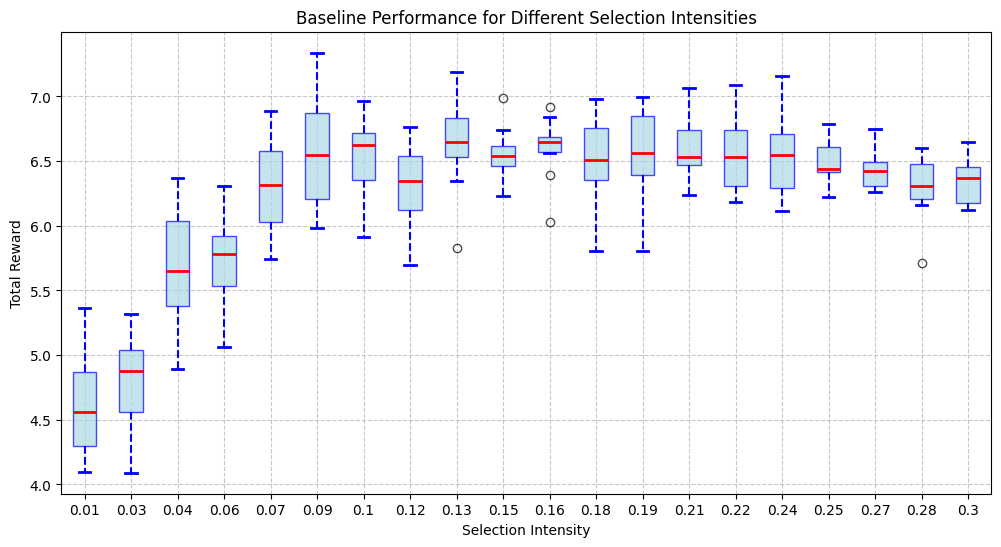

In [45]:
# Calculate baselines
baselines, best_avg_baseline, best_intensity = collect_baselines(env, selection_intensities=np.linspace(0.01, 0.3, 20), num_reps=10)
print(f"Best average baseline: {best_avg_baseline:.2f} (intensity: {best_intensity:.2f})")

# Visualize baselines if needed
visualize_baselines(baselines)

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import random

def collect_baselines(env, num_episodes=1, selection_intensities=[0.1, 0.2, 0.3, 0.4, 0.5], num_reps=3):
    baselines = {}
    best_avg_baseline = float('-inf')
    best_intensity = None
    best_genetic_variance = None

    for intensity in selection_intensities:
        all_rewards = []
        all_genetic_variances = []
        for _ in range(num_reps):
            rewards = []
            genetic_variances = []
            for _ in range(num_episodes):
                obs, _ = env.reset()
                done = False
                episode_reward = 0
                while not done:
                    action = np.array([intensity])
                    obs, reward, done, _, info = env.step(action)
                    episode_reward += reward
                    if done:
                        genetic_variances.append(info['genetic_variance'])
                rewards.append(episode_reward)
            all_rewards.extend(rewards)
            all_genetic_variances.extend(genetic_variances)
        
        avg_reward = np.mean(all_rewards)
        avg_genetic_variance = np.mean(all_genetic_variances)
        baselines[intensity] = {'rewards': all_rewards, 'genetic_variances': all_genetic_variances}
        
        if avg_reward > best_avg_baseline:
            best_avg_baseline = avg_reward
            best_intensity = intensity
            best_genetic_variance = avg_genetic_variance

    # Add random baseline
    random_rewards = []
    random_genetic_variances = []
    for _ in range(num_reps):
        for _ in range(num_episodes):
            obs, _ = env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = np.array([random.uniform(0.01, 0.99)])
                obs, reward, done, _, info = env.step(action)
                episode_reward += reward
                if done:
                    random_genetic_variances.append(info['genetic_variance'])
            random_rewards.append(episode_reward)
    
    baselines['random'] = {'rewards': random_rewards, 'genetic_variances': random_genetic_variances}
    
    return baselines, best_avg_baseline, best_intensity, best_genetic_variance

def visualize_baselines(baselines):
    # Round the keys of baselines before visualization
    rounded_baselines = {round(float(key), 2) if isinstance(key, float) else key: baselines[key] for key in baselines.keys()}
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Prepare data for box plots
    rewards_data = [rounded_baselines[i]['rewards'] for i in sorted(rounded_baselines.keys(), key=lambda x: (x != 'random', x))]
    genetic_var_data = [rounded_baselines[i]['genetic_variances'] for i in sorted(rounded_baselines.keys(), key=lambda x: (x != 'random', x))]
    
    # Create box plots for rewards
    bp1 = ax1.boxplot(rewards_data, patch_artist=True)
    
    # Customize the rewards box plot
    for box in bp1['boxes']:
        box.set(facecolor='lightblue', edgecolor='blue', alpha=0.7)
    for whisker in bp1['whiskers']:
        whisker.set(color='blue', linewidth=1.5, linestyle='--')
    for cap in bp1['caps']:
        cap.set(color='blue', linewidth=2)
    for median in bp1['medians']:
        median.set(color='red', linewidth=2)
    for flier in bp1['fliers']:
        flier.set(marker='o', color='darkblue', alpha=0.7)

    ax1.set_xlabel('Selection Intensity')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Baseline Reward Performance for Different Selection Intensities')
    ax1.set_xticklabels(sorted(rounded_baselines.keys(), key=lambda x: (x != 'random', x)))
    ax1.grid(True, linestyle='--', alpha=0.7)
    plt.setp(ax1.get_xticklabels(), rotation=90)  # Rotate x-axis labels

    # Create box plots for genetic variances
    bp2 = ax2.boxplot(genetic_var_data, patch_artist=True)
    
    # Customize the genetic variance box plot
    for box in bp2['boxes']:
        box.set(facecolor='lightgreen', edgecolor='green', alpha=0.7)
    for whisker in bp2['whiskers']:
        whisker.set(color='green', linewidth=1.5, linestyle='--')
    for cap in bp2['caps']:
        cap.set(color='green', linewidth=2)
    for median in bp2['medians']:
        median.set(color='red', linewidth=2)
    for flier in bp2['fliers']:
        flier.set(marker='o', color='darkgreen', alpha=0.7)

    ax2.set_xlabel('Selection Intensity')
    ax2.set_ylabel('Genetic Variance')
    ax2.set_title('Genetic Variance for Different Selection Intensities')
    ax2.set_xticklabels(sorted(rounded_baselines.keys(), key=lambda x: (x != 'random', x)))
    ax2.grid(True, linestyle='--', alpha=0.7)
    plt.setp(ax2.get_xticklabels(), rotation=90)  # Rotate x-axis labels

    plt.tight_layout()
    plt.show()

# Usage example:
# baselines, best_avg_baseline, best_intensity, best_genetic_variance = collect_baselines(env, selection_intensities=np.linspace(0.01, 0.1, 20), num_reps=10)
# print(f"Best average baseline: {best_avg_baseline:.2f} (intensity: {best_intensity:.2f})")
# print(f"Genetic variance for best baseline: {best_genetic_variance:.4f}")
# visualize_baselines(baselines)

/tmp/ipykernel_409321/1968126224.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_select = max(1, min(int(selection_intensity * population.pop_size), population.pop_size - 1))
/tmp/ipykernel_409321/3288625130.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'selection_intensity': float(action),


Best average baseline: 6.92 (intensity: 0.19)
Random baseline average: 0.04


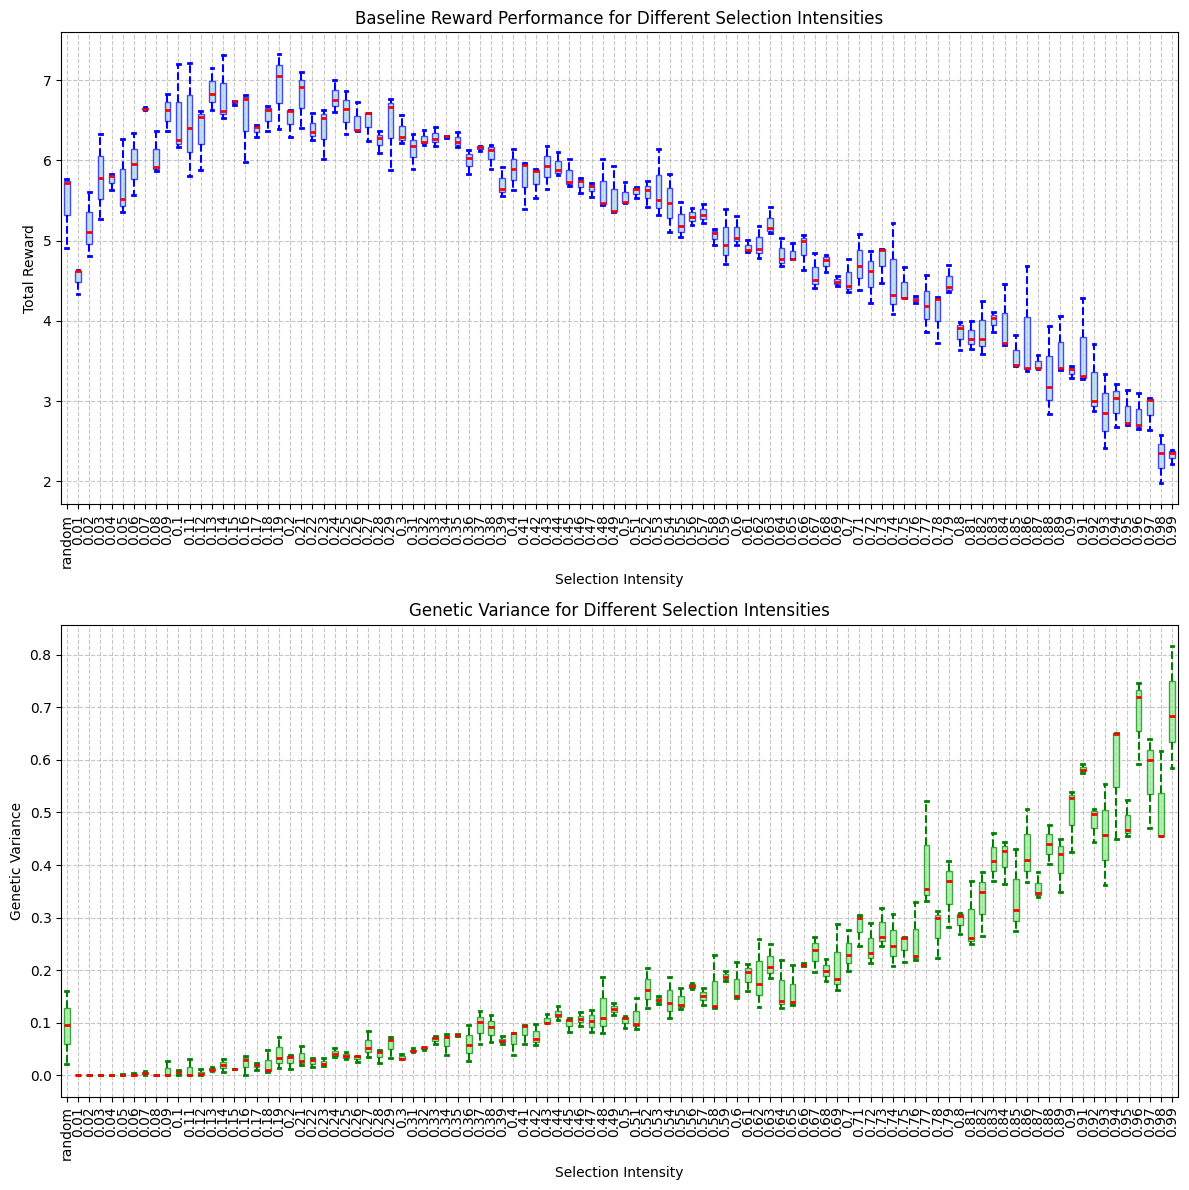

In [67]:

# Usage example:
baselines, best_avg_baseline, best_intensity, random_avg_reward = collect_baselines(env, selection_intensities=np.linspace(0.01, 0.99, 99), num_reps=3)
print(f"Best average baseline: {best_avg_baseline:.2f} (intensity: {best_intensity:.2f})")
print(f"Random baseline average: {random_avg_reward:.2f}")
visualize_baselines(baselines)

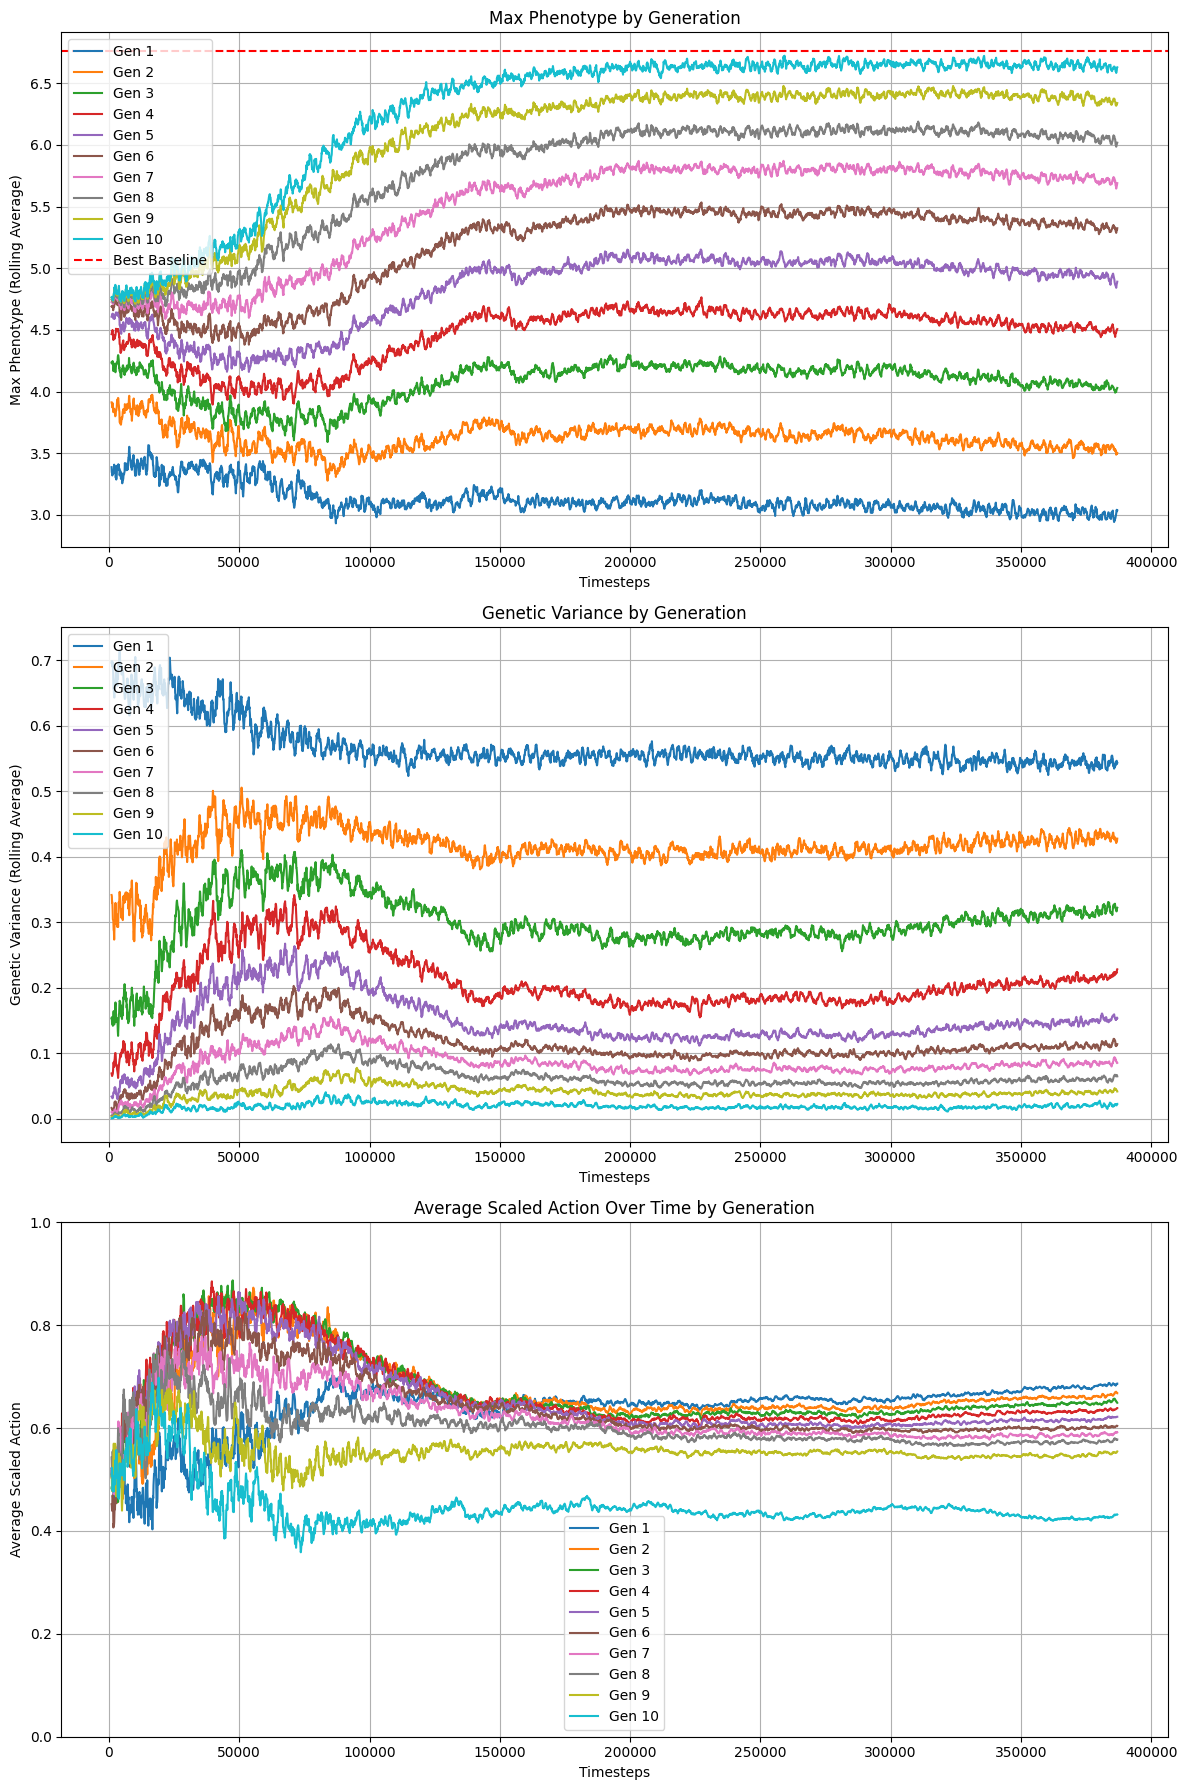

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10           |
|    ep_rew_mean          | 6.64         |
| time/                   |              |
|    fps                  | 12           |
|    iterations           | 189          |
|    time_elapsed         | 31144        |
|    total_timesteps      | 387072       |
| train/                  |              |
|    approx_kl            | 0.0018153635 |
|    clip_fraction        | 0.0969       |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.09         |
|    explained_variance   | 0.442        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0133       |
|    n_updates            | 1880         |
|    policy_gradient_loss | 0.00336      |
|    std                  | 0.0301       |
|    value_loss           | 0.0451       |
------------------------------------------


KeyboardInterrupt: 

In [63]:
# Set up the environment

# Set up the model and callback
model = PPO("MultiInputPolicy", env, device='cuda', verbose=1, tensorboard_log=tensorboard_log)
custom_callback = CustomCallback(baseline=best_avg_baseline)

# Train the model
model.learn(total_timesteps=total_timesteps, callback=custom_callback)